<a href="https://colab.research.google.com/github/99093003626/Armando/blob/master/PyAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # Generador de Señales. Tarjeta de Audio

Experimental II -- Instituto Balseiro  

Armando Palacio Romeu. 

---
\
###Resumen:
> Para la realización de este trabajo me propuse varios objetivos. Uno de ellos crear un osciloscopio que logre capturar una señal de audio a través del micrófono del ordenador, para luego visualizar su representación temporal y también su representación frecuencial. Para ello utilizaré una librería de representación gráfica en Python llamada PyQtGraph. He elegido esta librería porque proporciona un tiempo de procesado aceptable para poder hacer una representación gráfica en tiempo real de la señal de audio. En unas pruebas preliminares que hice con la librería estándar de Python para gráficos Matplotlib, no conseguí unos resultados aceptables en cuanto a la visualización de la señal, ya que no es una librería optimizada para este tipo de representaciones en tiempo real. Como segundo objetivo me propuse crear varias señales periódicas en tiempo, de esta forma reproducir el audio que generan y graficar tanto su propia señal en función del tiempo como su espectro en frecuencia. Como tercer objetivo me propuse crear efectos de batidos mezclando varias señales con distintas frecuencias y amplitud, y luego crear un popurrí de la unión temporal de dichas señales más que nada para escuchar su sonido con la evolución de la frecuencia. Y para terminar como cuarto y último objetivo grabar 10 segundos de una canción y observar la onda sonora y su espectro en frecuencia. Para el desarrollo de este proyecto utilicé la librería PyAudio para la manipulación del micrófono y los altavoces de la PC.
Todo el código fuente lo pueden encontrar [aquí](https://github.com/99093003626/Armando/blob/master/PyProyect.py).


### Explicación del código:
Comencé creando una **clase** a la cual llamé **Audio**, la misma contiene a la funcion '*initPlot()*' la cual se encarga de mostrar el entorno que contendrá los gráficos que representan la señal tanto en tiempo como en frecuencia, además se encarga de fijar el rango y títulos de los ejes. Y la función '*update()*' la cual se encarga de tomar las muestras de audio del micrófono, convertirlas en arreglos de **numpy**, aplicarle la Transformada Rápida de Fourier o *FFT* en inglés y luego agregar los datos a los gráficos del osciloscopio. 



In [ ]:
class Audio():
    def __init__(self,CHANNELS, CHUNK, FRAME_RATE, layout, w):
        self.channels = CHANNELS
        self.chunk = CHUNK
        self.fs = FRAME_RATE
        self.lay = layout
        self.w = w
        self.plt1 = pg.PlotWidget()
        self.plt2 = pg.PlotWidget()
        self.lay.addWidget(self.plt1, 1, 0)
        self.lay.addWidget(self.plt2, 1, 1)
    
    def initPlot(self):
        self.plt1.setYRange(-0.5, 0.5)
        self.plt1.getPlotItem().setTitle(title="Representación temporal")
        self.plt1.getAxis('bottom').setLabel('Tiempo',units='ms')
        self.plt1.getAxis('bottom').enableAutoSIPrefix(enable=True)
        self.plt1.getAxis('left').setLabel('Amplitud')
        self.plt2.getPlotItem().setTitle(title="Representación frecuencial (FFT)")
        self.plt2.getAxis('bottom').setLabel('Frecuencia (kHz)')
        self.plt2.setYRange(0, 60)
        self.plt2.getAxis('bottom').enableAutoSIPrefix(enable=True)
        self.plt2.getAxis('left').setLabel('Nivel')
        self.w.show()
        
    def update(self):
        p = pyaudio.PyAudio()
        stream = p.open(format=pyaudio.paFloat32,channels=self.channels,rate=self.fs, input=True, frames_per_buffer=self.chunk)
        data_bytes = stream.read(self.chunk)

        if not data_bytes:
            print("no data")
        else:
            #Señal Temporal (ms)
            data = self.a_ndarray(data_bytes,np.float32)
            t = (np.linspace(0,self.chunk/self.fs,self.chunk))*1000 
            self.plt1.plot(t[50:], data[50:], pen=(255,0,0), clear=True)
            
            #Frecuencia (kHz)
            A = np.fft.fftshift(np.fft.fft(data))
            freq = np.fft.fftshift(np.fft.fftfreq(len(data)))*self.fs/1000
            i = int(len(freq)/2) #Contador a partir de las frecuencias > 0
            #f = int(3*len(freq)/4)
            self.plt2.plot(freq[i:],np.abs(A)[i:], pen=(255,0,0), clear=True)
        stream.stop_stream()
        stream.close()
        p.terminate()


Además contiene una serie de funciones periódicas las cuales pueden ser modificadas según frecuencia, tiempo de duración o amplitud, en este caso volumen de la señal. Fue muy sencillo constriur la mayoría de estas funciones usando la libreria **Scipy.Signal** y las demás las hice usando algunas previamente construidas. 



In [ ]:
    def sin(self, f, time = 5, volumen = 1): 
        return volumen*np.sin(2*np.pi*np.arange(self.fs*time)*f/self.fs)

    def sin_plus(self, f, time = 5, volumen = 1):
        a = self.sin(f,time,volumen)
        for i in range(len(a)):
            if a[i] < 0:
                a[i]=0
        return a

    def sin_abs(self, f, time = 5, volumen = 1):
        return np.abs(self.sin(f/2,time,volumen))

    def triangular(self, f, time = 5, volumen = 1):
        return volumen*signal.sawtooth(2*np.pi*f*(np.arange(self.fs*time)/self.fs),0.5)

    def triangular_plus(self, f, time = 5, volumen = 1):
        a = self.triangular(f,time,volumen)
        for i in range(len(a)):
            if a[i] < 0:
                a[i]=0
        return a  

    def triangular_abs(self, f, time = 5, volumen = 1):
        return np.abs(self.triangular(f/2,time,volumen))    

    def sierra(self, f, time = 5, volumen = 1):
         return volumen*signal.sawtooth(2*np.pi*f*(np.arange(self.fs*time)/self.fs))

    def square(self, f, time = 5, volumen = 1):
        return volumen*signal.square(2*np.pi*f*(np.arange(self.fs*time)/self.fs))

    def square_plus(self, f, time = 5, volumen = 1):
        a = self.square(f,time,volumen)
        for i in range(len(a)):
            if a[i] < 0:
                a[i]=0
        return a

También contiene las funciones '*play()*' que reproduce el audio dado un arreglo o una cadena de bytes. La función '*plot()*' que grafica la señal en tiempo dado un array o una cadena de bytes también. La función '*plotfft()*' que grafica el espectro de frecuencias de la señal. La función '*plot_together()*' une las gráficas de las dos funciones anteriores en una sola.
La función '*grabar()*' que como su nombre lo dice devuelve un archivo de audio '.wav' de duración definida por el usuario y además devuelve el arreglo correspondieente a dicha pista de audio.


In [ ]:
    def play(self, data, format_pyaudio = pyaudio.paFloat32, format_numpy = np.float32): #Reproduce el sonido de la señal de audio
        if type(data)==np.ndarray:
            data = self.a_bytes(data,format_numpy)
        p = pyaudio.PyAudio()
        stream = p.open(format=format_pyaudio, channels=self.channels, rate=self.fs, output=True)
        stream.write(data)
        stream.stop_stream()
        stream.close()
        p.terminate()

    def plot(self, data, format = np.float32, save = False, show = True, t_init = 0, t_end = 1): #Grafica la señal de audio
        if type(data)==bytes:
            data = self.a_ndarray(data,format)
        t = np.linspace(0, len(data)/self.fs, len(data))
        plt.plot(t,data)
        plt.xlim(t_init, t_end)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud')
        if save:
            plt.savefig(str(sum(data))+'.jpg')
        if show:
            plt.show()

    def plotfft(self, data, format = np.float32, save = False, show = True): #Grafica el espectro de frecuencia de la señal de audio
        if type(data)==bytes:
            data = self.a_ndarray(data,format)
        A = np.fft.fftshift(np.fft.fft(data))
        freq = np.fft.fftshift(np.fft.fftfreq(len(data)))*self.fs #/1000
        plt.semilogx(freq,np.abs(A))
        plt.xlim(10,20000)
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Nivel')
        if save:
            plt.savefig(str(sum(data)+1)+'.jpg')
        if show:
            plt.show()

    def plot_together(self, data, format = np.float32, t_init=0, t_end=1, save = False):
        plt.subplot(2,1,1)
        self.plot(data, format, show = False, t_init = t_init, t_end = t_end)
        plt.subplot(2,1,2)
        self.plotfft(data, format, show = False)
        if save:
            plt.savefig(str(sum(data)+1)+'.jpg')
        plt.show()

    def grabar(self, time, name_file = None):
        audio=pyaudio.PyAudio()
        stream=audio.open(format=pyaudio.paInt16,channels=self.channels, rate=self.fs, input=True, frames_per_buffer=self.chunk)
        print("grabando...")
        frames=[]
        for i in range(0, int(self.fs/self.chunk*time)):
            data=stream.read(self.chunk)
            frames.append(data)
        print("grabación terminada")
        stream.stop_stream()
        stream.close()
        audio.terminate()
        if name_file:
            wf.write(name_file, self.fs, self.a_ndarray(b''.join(frames),np.int16))
            return self.a_ndarray(b''.join(frames),np.int16)
        else:
            return self.a_ndarray(b''.join(frames),np.int16)


Por último tenemos la función '*normal()*' que devuelve un arreglo con valores entre 0 y 1 para audios con arreglos de tipo 'float32'. En caso de que el tipo de dato del audio sea 'int16' los valores del arreglo estarán entre -32768 y 32767, este tipo de dato es mayormente usado por archivos '.wav'. Y las funciones '*a_bytes()*' y '*a_ndarray()*' que convierten un 'numpy.ndarray' a una cadena de 'bytes' y de una cadena de 'bytes' a 'numpy.ndarray' respectivamente.

In [ ]:
    def normal(self,data):
        return data/max(np.abs(data))

    def a_bytes(self,data,format):
        if format == np.float32:
            return data.astype(np.float32).tobytes()
        elif format == np.int16:
            return data.tobytes()

    def a_ndarray(self,data,format):
        return np.frombuffer(data,dtype=format)  

Y ese sería todo el contenido de la **clase Audio**. Luego fuera de la clase creé el entorno que contendrá los gráficos del osciloscopio usando los siguientes comandos.   

In [ ]:
app = QtGui.QApplication([])
w = QtGui.QWidget()
layout = QtGui.QGridLayout()
w.setLayout(layout)
w.setWindowTitle("Procesado de señal de audio en tiempo real")
w.setFixedSize(1000,500)
p = w.palette()
p.setColor(w.backgroundRole(), pg.mkColor('b'))
w.setPalette(p)
pg.setConfigOptions(antialias=True)

Y por último definimos una nueva función cuyo objetivo es encender el osciloscopio. Una vez esté encendido solo se podrá cerrar manualmente cerrando la ventana. Esto sería todo el codigo. En lo que sigue lo utilizaremos para las tareas que nos propusimos inicialmente.

In [ ]:
def init_osciloscopio(audio):
    audio.initPlot()

    timer = pg.QtCore.QTimer()
    timer.timeout.connect(audio.update)
    timer.start(0)

    if __name__ == '__main__':
        if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
            QtGui.QApplication.instance().exec_()

 ### Desarrollo:
 Importamos todas las librerías necesarias para la utilización del código.

In [ ]:
import time
import sys
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg
from scipy import signal

Definimos la frecuencia de muestreo 'fs', el tamaño del paquete a procesar por PyAudio 'chunk', esto es el tamaño del pakete de audio captado por el micrófono que se enviará al osciloscopio para su procesado en tiempo real, y el número de canales 'channels' de audio a capturar. Ahora iniciamos un objeto de tipo **Audio** y encendemos el osciloscopio.   

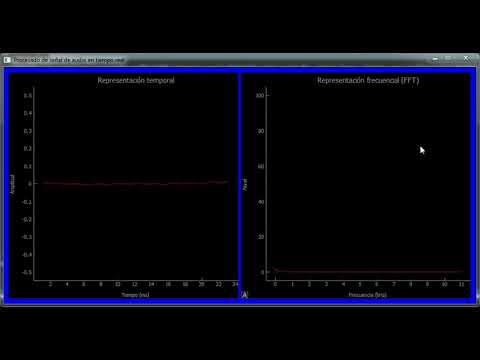

In [72]:
fs = 44100   
chunk = 1024
channels = 1 

a = Audio(channels,chunk,fs,layout,w)

init_osciloscopio(a)


El [video](https://youtu.be/lSxIaAACcrA) mustra el funcionamiento del mismo. Para esto utilicé una aplicación para el movil [Generador de frecuencia](https://https://play.google.com/store/apps/details?id=com.boedec.hoel.frequencygenerator&hl=es_419) la cual me permite variar la frecuencia de una señal senoidal en todo el rango audible y se puede ver claramente en el osciloscopio como se mueve el pico a medida que cambia la frecuencia.



Ahora graficamos todas las funciones periódicas creadas anteriormente a una misma frecuencia 'f' en este caso 100 Hz. Las imágenes muestran los resultados en tiempo y frecuencia para cada señal.

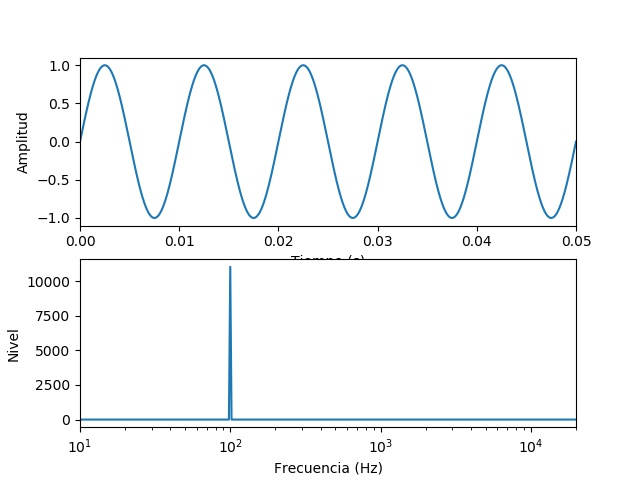

In [75]:
f = 100
data = [a.sin(f,0.5), a.sin_plus(f,0.5), a.sin_abs(f,0.5), a.triangular(f,0.5), a.triangular_plus(f,0.5), a.triangular_abs(f,0.5), a.sierra(f,0.5), a.square(f,0.5), a.square_plus(f,0.5)]
for d in data:
    a.play(d)
    a.plot_together(d, t_end=5/f, save = True) # Para save=True guarda las imagenes

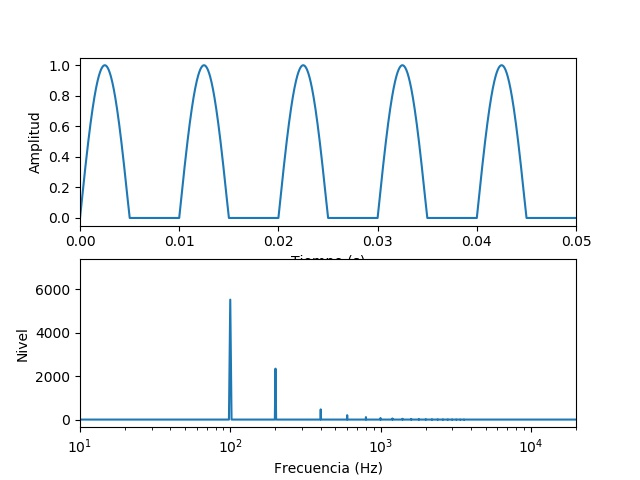

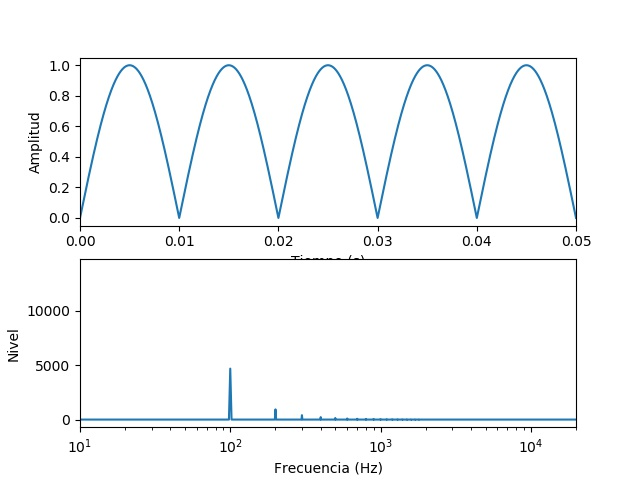

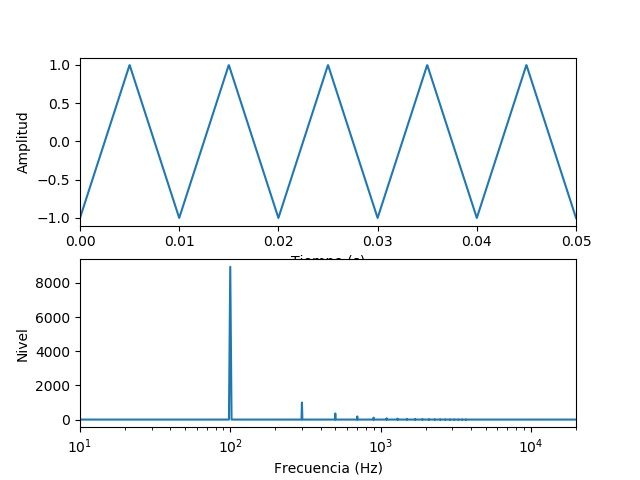

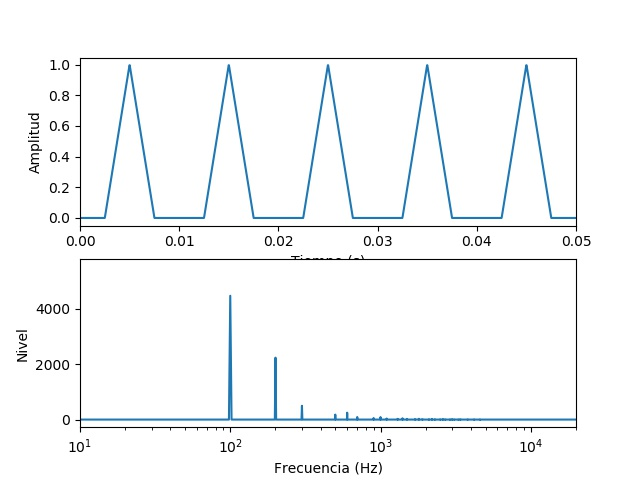

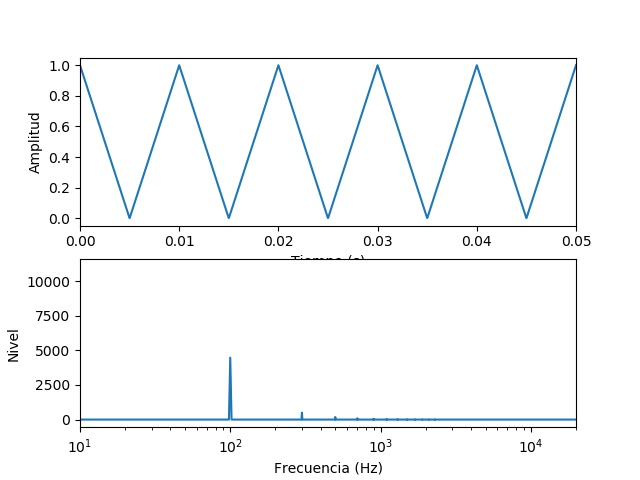

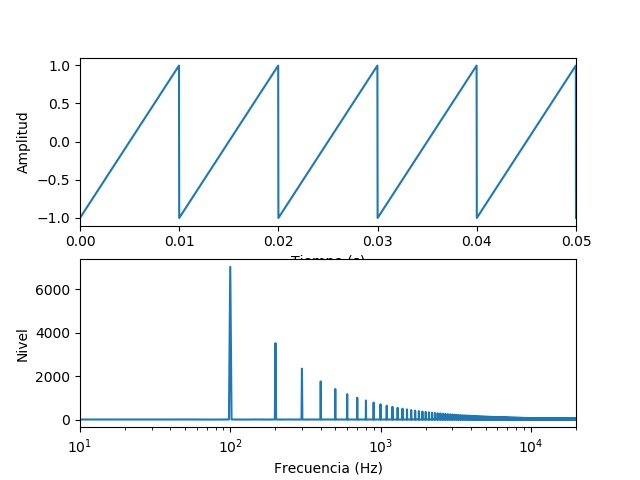

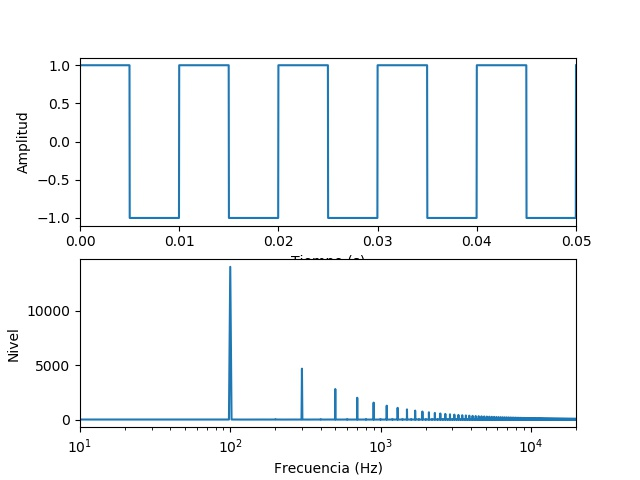

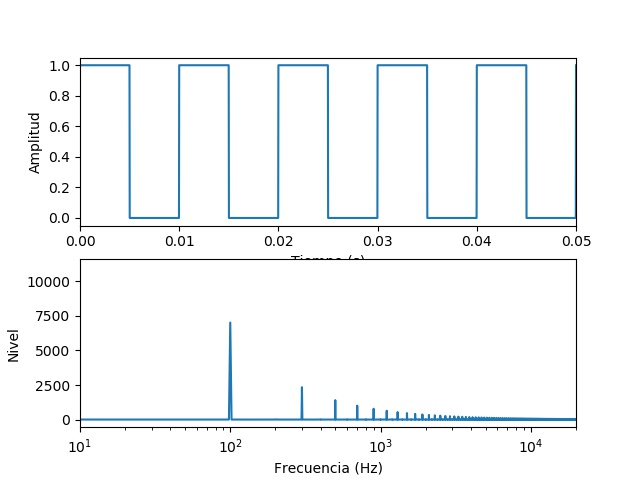

De esta forma se puede observar cuales son las frecuencias que componen a las señales antes mencionadas. 

Para continuar seleccioné la función seno e hice una composición de varias de estas funciones con distintas frecuencias y amplitudes, para ello seleccione 300, 400, 440 y 700 Hz como se muestra a continuación. Es necesario normalizar los datos ya que al sumar varias funciones dejarían de estar entre -1 y 1. Reproducimos el audio y graficamos tanto la parte temporal como la frecuencial.

In [87]:
data = a.sin(400,1) + a.sin(300,1) + a.sin(440,1,volumen=0.5) + a.sin(700,1,volumen=0.3)
data = a.normal(data)
a.play(data)
a.plot_together(data, t_end = 0.2, save = False)

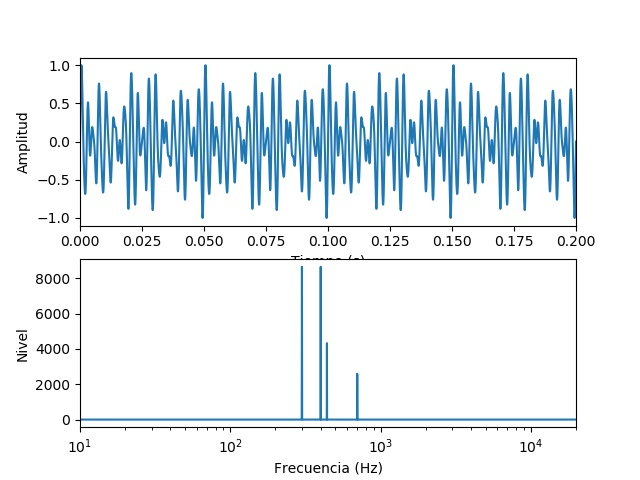

Podemos apreciar en el espectro de frecuencias que efectivamente contiene las frecuencias antes usadas y además con los pesos correspondientes a cada una de ellas.

Si tomamos ahora senoidales con frecuencias que van de 100 Hz a 1000 Hz con un paso de 100 Hz, pero en lugar de sumarlas creamos un dataset donde colocamos cada señal a continuación de la otra y seleccionamos aleatoriamente su amplitud, podremos escuchar la evolución del sonido con la frecuencia. Para esto implementé el siguiente código. 

In [89]:
data = a.sin(f=100, time=0.5, volumen=np.random.rand())
for i in range(200,1000,100):
    data = np.append(data, a.sin(f=i,time=0.5,volumen=np.random.rand()))
for i in range(1000,100,-100):
    data = np.append(data, a.sin(f=i,time=0.5,volumen=np.random.rand()))
a.play(data)
a.plot_together(data,t_end=9, save = True)
wf.write('popurri.wav', fs, data)

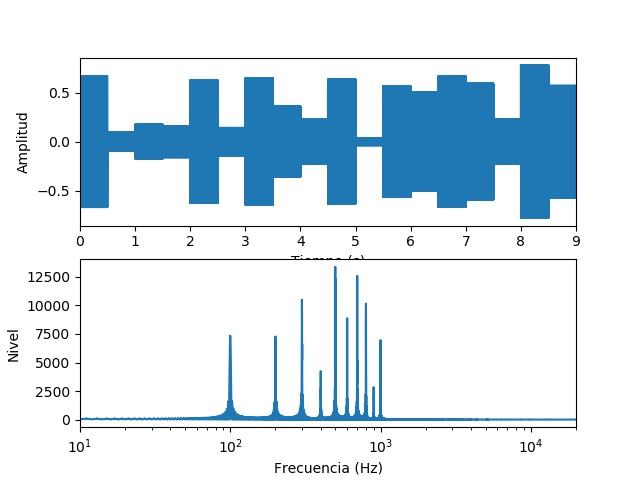

Por último grabamos 10 segundos de alguna canción captada por el micrófono y miramos como se ve su espectro en frecuencia y su señal temporal. Además grabamos 10 segundos más para analizar el ruido de fondo.

In [91]:
data = a.grabar(time=10, name_file = 'song.wav')
a.play(data, pyaudio.paInt16, np.int16)
a.plot_together(data,t_end=5, save = True)


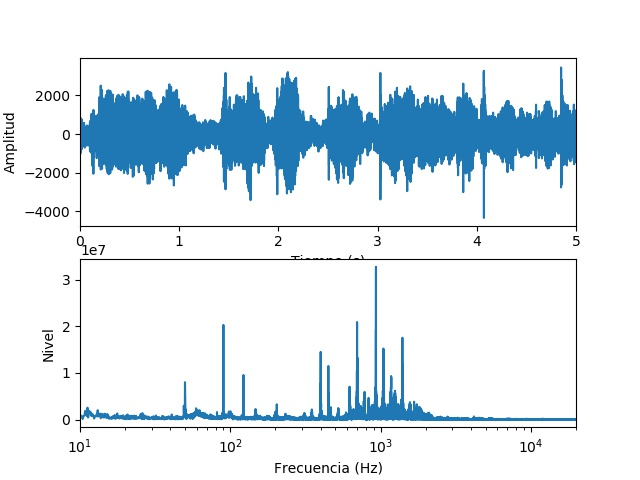

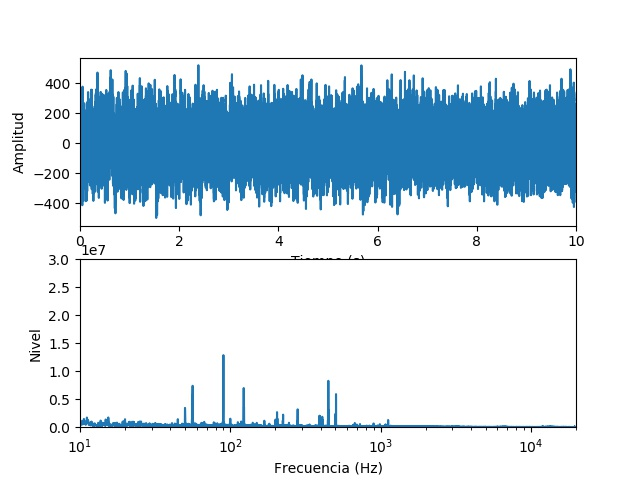

Como podemos apreciar hay frecuencias con peso no despreciable en ambos espectros, esto nos da a entender que hay ruido de fondo y frecuencias que no corresponden al sonido de la canción, si escuchamos el audio notamos que no está del todo nítido, lo cual nos lleva a la conclusión de que el micrófono no es de muy buena calidad, teniendo en cuenta el poco ruido que había en el momento de la grabación. 

Son infinitas las cosas que se pueden probar y hacer respecto a este tema. Algo que sería interesante es aplicar filtros para mejorar la salida de audio del micrófono en tiempo real.

## **Fin!!**